In [1]:
import os
import copy
import time
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt
import torch
import torchvision
import torchvision.transforms.functional as TF 
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch import optim 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ShuffleSplit
from torch.utils.tensorboard import SummaryWriter
import random
np.random.seed(0)
random.seed(0)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(os.path.join("D:\dataSmoke","runs"))

In [3]:
class Smoke_dataset(Dataset):
    def __init__(self,path2data, transform=None,trans_params=None):
        if trans_params["p_hflip"] > 0:
            path2dataf = os.path.join(path2data,"train")
            path2labels = os.path.join(path2dataf,"train_labels.csv")
        else:
            path2dataf = os.path.join(path2data,"valid")
            path2labels = os.path.join(path2dataf,"valid_labels.csv")
        labels_df = pd.read_csv(path2labels)
        x_min = labels_df["xmin"]
        y_min = labels_df["ymin"]
        x_max = labels_df["xmax"]
        y_max = labels_df["ymax"]
        labels_df["centerx"] = x_min+(x_max - x_min)/2
        labels_df["centery"] = y_min+(y_max - y_min)/2
        labels_df["w"] = (x_max - x_min)
        labels_df["h"] = (y_max - y_min)
        self.labels = labels_df[["centerx","centery","w","h"]].values
        self.imgName = labels_df["filename"]
        print(labels_df.head())
        
        self.ids = labels_df.index
        self.fullPath2img = [0]*len(self.ids)
        for id_ in self.ids:
            if trans_params["p_hflip"] > 0:
                self.fullPath2img[id_]=os.path.join(path2data,"train",self.imgName[id_])
            else:
                self.fullPath2img[id_]=os.path.join(path2data,"valid",self.imgName[id_])
        self.transform = transform
        self.trans_params = trans_params
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        image = Image.open(self.fullPath2img[idx])
        label = self.labels[idx]
        if self.transform:
            image,label = self.transform(image,label,self.trans_params)
        return image, label

In [14]:
path2data = "D:\dataSmoke"
def resize_img_label(image,label = (0.,0.),target_size = (256,256)):
    w_orig,h_orig = image.size
    w_target,h_target = target_size
    cx, cy = label
    image_new = TF.resize(image,target_size)
    label_new = cx/w_orig*w_target, cy/h_orig*h_target
    return image_new,label_new

def random_hflip(image,label):
    w,h = image.size
    x,y = label
    image = TF.hflip(image)
    label = w-x, y
    return image,label

def random_vflip(image,label):
    w,h = image.size
    x,y = label
    image = TF.vflip(image)
    label = x,w-y
    return image, label

def random_shift(image,label,max_translate=(0.2,0.2)):
    w,h = image.size
    max_t_w,max_t_h = max_translate
    cx,cy = label
    trans_coef = np.random.rand()*2 - 1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)
    image=TF.affine(image,translate=(w_t,h_t),shear=0,angle=0,scale=1)
    label = cx+w_t, cy+h_t
    return image, label

def grayscale(image,label):
    image = TF.to_grayscale(image,3)
    return image, label

def rotation(image,label):
    w,h = image.size
    angle = random.randrange(-30, 30)
    angle_l = -angle/57.3
    #angle = -30
    #angle_l = np.pi/6
    image = TF.rotate(image,angle)
    
    label_1 = (label[0]*w-w/2)*np.cos(angle_l)-(label[1]*h-h/2)*np.sin(angle_l)+w/2
    label_2 = (label[0]*w-w/2)*np.sin(angle_l)+(label[1]*h-h/2)*np.cos(angle_l)+h/2
    label[0] = label_1
    label[1] = label_2
    label[0] =label[0]/w
    label[1] =label[1]/h
    
    return image, label

def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

def transformer(image, label, params):
    flag = 0
    origW,origH = image.size
    labelSizeW = label[2]
    labelSizeH = label[3]
    label = [label[0],label[1]]
    image,label = resize_img_label(image,label,params["target_size"])
    if random.random() < params["p_hflip"]:
        image,label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if  flag == 0 and random.random() < params["p_shift"]:
        image, label = random_shift(image,label,params["max_translate"])
        flag = 1
    if random.random() < params["p_brightness"]:
        brightness_factor = 1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image,brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma = 1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)
    if params["scale_label"]:
        label = scale_label(label,params["target_size"])
        
    if random.random() < params["p_gray"]:
        image,label=grayscale(image,label)
    if flag == 0 and random.random() < params["p_rotate"]:
        image,label=rotation(image,label)
        flag = 1
    print(image.size)
    image=TF.to_tensor(image)
    print(image.shape)
    label = [label[0],label[1],labelSizeW/origW,labelSizeH/origH]
    return image, label

In [15]:
trans_params_train={
    "target_size":(256,256),
    "p_hflip":0.5,
    "p_vflip":0.5,
    "p_shift":0.5,
    "max_translate":(0.2,0.2),
    "p_brightness":0.5,
    "brightness_factor":0.2,
    "p_contrast":0.5,
    "contrast_factor":0.2,
    "p_gamma":0.5,
    "p_gray" : 0.5,
    "p_rotate":0.0,
    "gamma":0.2,
    "scale_label":True,
}

In [16]:
trans_params_val={
    "target_size":(256,256),
    "p_hflip":0.0,
    "p_vflip":0.0,
    "p_shift":0.0,
    "p_brightness":0.0,
    "p_contrast":0.0,
    "p_gamma":0.0,
    "p_gray" : 0.0,
    "p_rotate":0.0,
    "gamma":0.0,
    "scale_label":True,
}

In [17]:
train_ds = Smoke_dataset(path2data,transformer,trans_params_train)
val_ds = Smoke_dataset(path2data,transformer,trans_params_val)
print(train_ds[0][1])

                                            filename  width  height  class  \
0  ck0qd8gs6ko7j0721x25cv4o3_jpeg.rf.005f5707706e...    640     480  smoke   
1  ck0t40rhdz68s0a46ekx049a6_jpeg.rf.00403179fe5f...    640     480  smoke   
2  ck0m0ch9ugnna07940o8x989j_jpeg.rf.0101cdb46a16...    640     480  smoke   
3  ck0rr6bfa9b3w0721aw5unwdy_jpeg.rf.00982c053d66...    640     480  smoke   
4  ck0uk75x5ysls0721e5a9j891_jpeg.rf.00d7fd8503e1...    640     480  smoke   

   xmin  ymin  xmax  ymax  centerx  centery    w   h  
0   125   190   177   286    151.0    238.0   52  96  
1   326   207   494   249    410.0    228.0  168  42  
2   308   166   582   257    445.0    211.5  274  91  
3   241   204   310   244    275.5    224.0   69  40  
4   523   208   619   288    571.0    248.0   96  80  
                                            filename  width  height  class  \
0  ck0k9aqm99o2o0721aml8qpqr_jpeg.rf.028c79a871f1...    640     480  smoke   
1  ck0ndrnhi3fkn0794vbn53c08_jpeg.rf.00da459d

In [20]:
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label=rescale_label([label[0],label[1]],img.shape[1:])
        x,y=label
        plt.plot(x,y,'b+',markersize=20)

def show_img_label(img,label=None,thickness=2):
    if label is not None:
        w = label[2]*img.shape[1:][0]
        h = label[3]*img.shape[1:][1]
        label=rescale_label([label[0],label[1]],img.shape[1:])
        cx,cy=label
        if torch.is_tensor(img):
            img = to_pil_image(img)
            print("iii:",img.size)
        draw = ImageDraw.Draw(img)
        draw.rectangle(((cx-w/2,cy-h/2),(cx+w/2,cy+h/2)),outline = "green",width = thickness)
    plt.imshow(np.asarray(img))

(256, 256)
torch.Size([3, 256, 256])
iii: (256, 256)
[0.8765625, 0.515625, 0.165625, 0.6645833333333333]


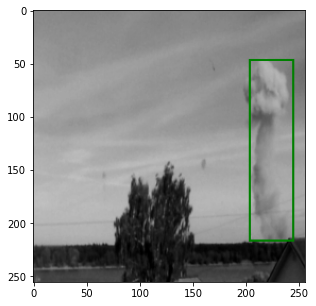

In [21]:
plt.figure(figsize=(5,5))
img,label = train_ds[521]
show_img_label(img,label)
#show(img,label)
#print(img.type())
print(label)

[0.8078125, 0.5, 0.0625, 0.04583333333333333]


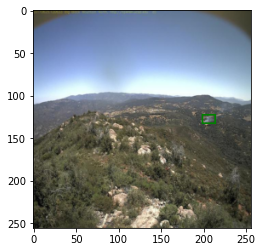

In [10]:
img,label = val_ds[10]
show_img_label(img,label)
#show(img,label)
#print(img.type())
print(label)

In [11]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds,batch_size=8,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=16,shuffle=False)

In [12]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.6133, 0.5922, 0.6961, 0.6609, 0.7359, 0.6828, 0.4688, 0.4086]), tensor([0.4977, 0.4276, 0.4458, 0.6844, 0.5198, 0.6135, 0.7482, 0.3604]), tensor([0.2625, 0.1969, 0.0516, 0.3906, 0.1312, 0.2812, 0.4297, 0.4547]), tensor([0.0875, 0.0729, 0.0417, 0.4437, 0.2812, 0.1021, 0.2146, 0.7208])]


In [13]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    label_b = torch.stack(label_b,1)
    label_b = label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 4]) torch.float32


In [14]:
for img_b,label_b in val_dl:
    print(img_b.shape,img_b.dtype)
    label_b = torch.stack(label_b,1)
    label_b = label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 4]) torch.float32


In [15]:
class Net(nn.Module):
    def __init__(self,params):
        super(Net, self).__init__()
        C_in,H_in,W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs=params["num_outputs"]
        self.conv1 = nn.Conv2d(C_in,init_f,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(init_f+C_in,2*init_f,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(16*init_f, num_outputs)
    def forward(self,x):
        identity = F.avg_pool2d(x,4,4)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim = 1)

        identity = F.avg_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x,identity),dim = 1)

        identity = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity),dim = 1)

        identity = F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2, 2)
        x = torch.cat((x, identity),dim = 1)

        x = F.relu(self.conv5(x))
        x = F.adaptive_avg_pool2d(x,1)
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        return x

In [16]:
params_model={
    "input_shape":(3,256,256),
    "initial_filters": 32,
    "num_outputs": 4,
}

model = Net(params_model)

In [17]:
test_im,test_label = train_ds[2]#
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
    writer.add_graph(model,test_im.unsqueeze(0).to(device))#
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(35, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(99, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(227, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(483, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=4, bias=True)
)


In [18]:
loss_func = nn.SmoothL1Loss(reduction="sum")
n,c = 8,4
y = 0.5 * torch.ones(n,c, requires_grad = True)
print(y.shape)

torch.Size([8, 4])


In [19]:
target = torch.zeros(n,c, requires_grad = False)
print(target.shape)

torch.Size([8, 4])


In [20]:
loss = loss_func(y, target)
print(loss.item())

4.0


In [21]:
y = 2 * torch.ones(n,c, requires_grad = True)
target = torch.zeros(n,c, requires_grad = False)
loss = loss_func(y,target)
print(loss.item())

48.0


In [22]:
from torch import optim 
opt = optim.Adam(model.parameters(),lr = 1e-3)

In [23]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
current_lr = get_lr(opt)
print('current lr = {}'.format(current_lr))

current lr = 0.001


In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt,mode = 'min',factor = 0.5,patience = 20,verbose = 1)
#from torch.optim.lr_scheduler import StepLR
#from torch.optim.lr_scheduler import MultiStepLR
#lr_scheduler = StepLR(opt, step_size=100, gamma=0.1)
#lr_scheduler = MultiStepLR(opt, milestones=[200,400], gamma=0.1)

In [25]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 5.0000e-04.
Epoch    43: reducing learning rate of group 0 to 2.5000e-04.
Epoch    64: reducing learning rate of group 0 to 1.2500e-04.
Epoch    85: reducing learning rate of group 0 to 6.2500e-05.


In [26]:
def cxcy2bbox(cxcy):
    return torch.cat((cxcy[:,:2] - cxcy[:,2:]/2,cxcy[:,:2]+cxcy[:,2:]/2),1)

In [27]:
torch.manual_seed(0)
cxcy = torch.rand(1,4)
print("center:",cxcy*256)

center: tensor([[127.0417, 196.6648,  22.6502,  33.7998]])


In [28]:
bb = cxcy2bbox(cxcy)
print("bounding box", bb*256)

bounding box tensor([[115.7166, 179.7649, 138.3668, 213.5647]])


In [29]:
import torchvision
def metrics_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    iou = torchvision.ops.box_iou(output,target)
    return torch.diagonal(iou,0).sum().item()
n,c = 8,4
target = torch.rand(n,c,device = device)
target = cxcy2bbox(target)
metrics_batch(target,target)

8.0

In [30]:
def loss_batch(loss_func,output,target,opt = None):
    loss = loss_func(output,target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(),metric_b

In [31]:
for xb,label_b in train_dl:
    label_b = torch.stack(label_b,1)
    label_b = label_b.type(torch.float32)
    label_b = label_b.to(device)
    
    l,m = loss_batch(loss_func,label_b,label_b)
    print(l,m)
    break

0.0 8.0


In [32]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data=len(dataset_dl.dataset)
    
    for xb,yb in dataset_dl:
        yb = torch.stack(yb,1)
        yb = yb.type(torch.float32).to(device)
        output = model(xb.to(device))
        loss_b,metric_b = loss_batch(loss_func,output,yb,opt)
        running_loss+=loss_b
        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

In [33]:
import copy
def train_val(model,params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl=params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    
    loss_history = {
        "train": [],
        "val":[],
    }
    metric_history={
        "train":[],
        "val":[],
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr = {}'.format(epoch,num_epochs-1,current_lr))
        model.train()
        train_loss,train_metric = loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        writer.add_scalar("training loss",train_loss,epoch)
        writer.add_scalar("training accuracy",train_metric,epoch)
        model.eval()
        with torch.no_grad():
            val_loss,val_metric = loss_epoch(model,loss_func,val_dl,sanity_check)
            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),path2weights)
                print("Copied best model weights!")
            lr_scheduler.step(val_loss)
            if current_lr != get_lr(opt):
                print("Loading best model weights!")
                model.load_state_dict(best_model_wts)
            print("train loss:%.6f,accuracy:%.2f"%(train_loss,100*train_metric))
            print("val loss:%.6f,accuracy:%.2f"%(val_loss,100*val_metric))
            print("-"*10)
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [34]:
loss_func = nn.SmoothL1Loss(reduction = "sum")
opt = optim.Adam(model.parameters(),lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt,mode='min',factor = 0.5,patience=20,verbose=1)
#lr_scheduler = StepLR(opt, step_size=100, gamma=0.1)
#lr_scheduler = MultiStepLR(opt, milestones=[200,400], gamma=0.1)

path2models = "D:\dataSmoke\models"
if not os.path.exists(path2models):
    os.mkdir(path2models)

#----------------------
#path2weights="D:\dataSmoke\modelsweights_smoothl3.pt"
#model.load_state_dict(torch.load(path2weights))
#----------------------
    
params_train={
    "num_epochs":500,
    "optimizer":opt,
    "loss_func":loss_func,
    "train_dl":train_dl,
    "val_dl":val_dl,
    "sanity_check":False,
    "lr_scheduler":lr_scheduler,
    "path2weights":path2models+"weights_smoothl7.pt",
}
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/499, current lr = 0.001
Copied best model weights!
train loss:0.105098,accuracy:3.08
val loss:0.047463,accuracy:6.63
----------
Epoch 1/499, current lr = 0.001
train loss:0.056138,accuracy:4.87
val loss:0.047909,accuracy:7.05
----------
Epoch 2/499, current lr = 0.001
Copied best model weights!
train loss:0.056165,accuracy:4.95
val loss:0.043882,accuracy:4.55
----------
Epoch 3/499, current lr = 0.001
train loss:0.052649,accuracy:5.25
val loss:0.045202,accuracy:2.85
----------
Epoch 4/499, current lr = 0.001
train loss:0.052351,accuracy:5.00
val loss:0.049837,accuracy:6.22
----------
Epoch 5/499, current lr = 0.001
Copied best model weights!
train loss:0.053555,accuracy:5.16
val loss:0.042523,accuracy:5.07
----------
Epoch 6/499, current lr = 0.001
train loss:0.052715,accuracy:4.70
val loss:0.045098,accuracy:6.20
----------
Epoch 7/499, current lr = 0.001
Copied best model weights!
train loss:0.053756,accuracy:4.98
val loss:0.041598,accuracy:5.20
----------
Epoch 8/499, current

train loss:0.016611,accuracy:19.39
val loss:0.011738,accuracy:28.26
----------
Epoch 69/499, current lr = 0.001
train loss:0.015268,accuracy:20.01
val loss:0.012464,accuracy:19.28
----------
Epoch 70/499, current lr = 0.001
Copied best model weights!
train loss:0.015002,accuracy:22.52
val loss:0.009704,accuracy:26.03
----------
Epoch 71/499, current lr = 0.001
train loss:0.015887,accuracy:20.73
val loss:0.012201,accuracy:21.09
----------
Epoch 72/499, current lr = 0.001
train loss:0.014877,accuracy:21.80
val loss:0.013116,accuracy:15.27
----------
Epoch 73/499, current lr = 0.001
train loss:0.013637,accuracy:24.07
val loss:0.010518,accuracy:24.99
----------
Epoch 74/499, current lr = 0.001
Copied best model weights!
train loss:0.012761,accuracy:24.78
val loss:0.009278,accuracy:34.22
----------
Epoch 75/499, current lr = 0.001
train loss:0.013475,accuracy:23.36
val loss:0.011151,accuracy:18.30
----------
Epoch 76/499, current lr = 0.001
train loss:0.014504,accuracy:24.00
val loss:0.0102

train loss:0.006746,accuracy:32.98
val loss:0.006785,accuracy:28.19
----------
Epoch 140/499, current lr = 0.001
train loss:0.006976,accuracy:34.10
val loss:0.005042,accuracy:35.83
----------
Epoch 141/499, current lr = 0.001
train loss:0.007901,accuracy:32.63
val loss:0.004815,accuracy:37.91
----------
Epoch 142/499, current lr = 0.001
train loss:0.006408,accuracy:36.44
val loss:0.005012,accuracy:38.19
----------
Epoch 143/499, current lr = 0.001
train loss:0.006725,accuracy:33.85
val loss:0.004880,accuracy:38.25
----------
Epoch 144/499, current lr = 0.001
train loss:0.007211,accuracy:33.23
val loss:0.005075,accuracy:38.16
----------
Epoch 145/499, current lr = 0.001
train loss:0.006299,accuracy:36.69
val loss:0.004895,accuracy:43.90
----------
Epoch 146/499, current lr = 0.001
train loss:0.006898,accuracy:34.48
val loss:0.005460,accuracy:41.16
----------
Epoch 147/499, current lr = 0.001
train loss:0.006872,accuracy:34.84
val loss:0.004745,accuracy:43.28
----------
Epoch 148/499, cu

train loss:0.004601,accuracy:43.57
val loss:0.003566,accuracy:47.62
----------
Epoch 210/499, current lr = 0.00025
train loss:0.004225,accuracy:43.39
val loss:0.003862,accuracy:48.96
----------
Epoch 211/499, current lr = 0.00025
Copied best model weights!
train loss:0.004952,accuracy:40.49
val loss:0.003252,accuracy:50.93
----------
Epoch 212/499, current lr = 0.00025
Copied best model weights!
train loss:0.004412,accuracy:44.35
val loss:0.003226,accuracy:50.21
----------
Epoch 213/499, current lr = 0.00025
train loss:0.004889,accuracy:43.01
val loss:0.003365,accuracy:49.54
----------
Epoch 214/499, current lr = 0.00025
train loss:0.004492,accuracy:43.64
val loss:0.003494,accuracy:50.67
----------
Epoch 215/499, current lr = 0.00025
train loss:0.004598,accuracy:44.38
val loss:0.003701,accuracy:48.05
----------
Epoch 216/499, current lr = 0.00025
train loss:0.004509,accuracy:43.57
val loss:0.003540,accuracy:46.98
----------
Epoch 217/499, current lr = 0.00025
train loss:0.004668,accura

train loss:0.004305,accuracy:42.04
val loss:0.002783,accuracy:51.21
----------
Epoch 279/499, current lr = 0.00025
train loss:0.003789,accuracy:44.46
val loss:0.003159,accuracy:48.66
----------
Epoch 280/499, current lr = 0.00025
train loss:0.004104,accuracy:44.55
val loss:0.004503,accuracy:34.61
----------
Epoch 281/499, current lr = 0.00025
Copied best model weights!
train loss:0.003534,accuracy:47.42
val loss:0.002506,accuracy:56.49
----------
Epoch 282/499, current lr = 0.00025
train loss:0.003785,accuracy:45.73
val loss:0.002898,accuracy:53.31
----------
Epoch 283/499, current lr = 0.00025
train loss:0.003889,accuracy:45.72
val loss:0.002636,accuracy:54.26
----------
Epoch 284/499, current lr = 0.00025
train loss:0.003838,accuracy:44.75
val loss:0.003083,accuracy:48.43
----------
Epoch 285/499, current lr = 0.00025
train loss:0.003725,accuracy:46.10
val loss:0.002679,accuracy:53.93
----------
Epoch 286/499, current lr = 0.00025
train loss:0.003618,accuracy:45.39
val loss:0.003049,

train loss:0.003366,accuracy:49.35
val loss:0.002489,accuracy:55.01
----------
Epoch 347/499, current lr = 6.25e-05
train loss:0.003206,accuracy:49.16
val loss:0.002492,accuracy:56.26
----------
Epoch 348/499, current lr = 6.25e-05
train loss:0.003112,accuracy:50.07
val loss:0.002530,accuracy:53.01
----------
Epoch 349/499, current lr = 6.25e-05
train loss:0.003226,accuracy:50.50
val loss:0.002531,accuracy:56.81
----------
Epoch 350/499, current lr = 6.25e-05
train loss:0.003039,accuracy:50.73
val loss:0.002393,accuracy:58.04
----------
Epoch 351/499, current lr = 6.25e-05
train loss:0.003062,accuracy:50.38
val loss:0.002379,accuracy:57.27
----------
Epoch 352/499, current lr = 6.25e-05
train loss:0.003179,accuracy:49.99
val loss:0.002364,accuracy:55.61
----------
Epoch 353/499, current lr = 6.25e-05
train loss:0.003205,accuracy:49.24
val loss:0.002392,accuracy:57.37
----------
Epoch 354/499, current lr = 6.25e-05
train loss:0.003405,accuracy:49.60
val loss:0.002412,accuracy:56.73
----

train loss:0.002894,accuracy:50.83
val loss:0.002319,accuracy:56.99
----------
Epoch 415/499, current lr = 1.5625e-05
train loss:0.003445,accuracy:49.25
val loss:0.002334,accuracy:56.61
----------
Epoch 416/499, current lr = 1.5625e-05
train loss:0.003139,accuracy:50.51
val loss:0.002338,accuracy:58.76
----------
Epoch 417/499, current lr = 1.5625e-05
train loss:0.002995,accuracy:50.53
val loss:0.002309,accuracy:58.58
----------
Epoch 418/499, current lr = 1.5625e-05
train loss:0.002720,accuracy:52.00
val loss:0.002309,accuracy:58.65
----------
Epoch 419/499, current lr = 1.5625e-05
train loss:0.002898,accuracy:51.80
val loss:0.002369,accuracy:57.73
----------
Epoch 420/499, current lr = 1.5625e-05
train loss:0.002881,accuracy:50.96
val loss:0.002353,accuracy:57.45
----------
Epoch 421/499, current lr = 1.5625e-05
train loss:0.003199,accuracy:50.80
val loss:0.002288,accuracy:58.32
----------
Epoch 422/499, current lr = 1.5625e-05
train loss:0.003123,accuracy:51.47
val loss:0.002291,acc

train loss:0.003285,accuracy:50.89
val loss:0.002262,accuracy:58.66
----------
Epoch 482/499, current lr = 1.953125e-06
train loss:0.002883,accuracy:50.47
val loss:0.002266,accuracy:58.51
----------
Epoch 483/499, current lr = 1.953125e-06
train loss:0.003004,accuracy:52.13
val loss:0.002269,accuracy:58.54
----------
Epoch 484/499, current lr = 1.953125e-06
train loss:0.003381,accuracy:52.47
val loss:0.002273,accuracy:58.43
----------
Epoch 485/499, current lr = 1.953125e-06
train loss:0.003040,accuracy:50.30
val loss:0.002278,accuracy:58.46
----------
Epoch 486/499, current lr = 1.953125e-06
train loss:0.002979,accuracy:51.55
val loss:0.002285,accuracy:58.47
----------
Epoch 487/499, current lr = 1.953125e-06
train loss:0.002636,accuracy:51.65
val loss:0.002280,accuracy:58.45
----------
Epoch 488/499, current lr = 1.953125e-06
train loss:0.003041,accuracy:50.40
val loss:0.002275,accuracy:58.58
----------
Epoch 489/499, current lr = 1.953125e-06
train loss:0.002792,accuracy:52.01
val l

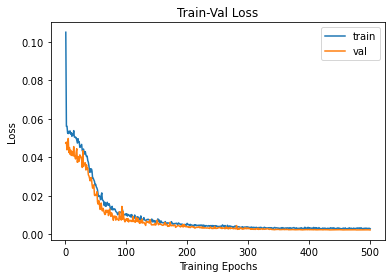

In [35]:
num_epochs = params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

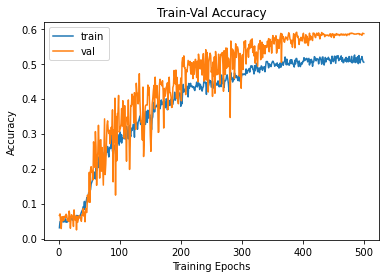

In [36]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [37]:
path2weights="D:\dataSmoke\modelsweights_smoothl7.pt"
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [38]:
loss_func = nn.SmoothL1Loss(reduction="sum")
with torch.no_grad():
    loss,metric = loss_epoch(model,loss_func,val_dl)
print(loss,metric)

0.002234481327349738 0.5859488565094617


In [39]:
def show_tensor_2labels(img,label1=None,label2=None,w_h=(100,100)):
    if label1 is not None:
        w1 = label1[2]*img.shape[1:][0]
        h1 = label1[3]*img.shape[1:][1]
        label1 = [label1[0],label1[1]]
        label1=rescale_label(label1,img.shape[1:])
    if label2 is not None:
        w2 = label2[2]*img.shape[1:][0]
        h2 = label2[3]*img.shape[1:][1]
        label2 = [label2[0],label2[1]]
        label2=rescale_label(label2,img.shape[1:])
    img=to_pil_image(img)
    
    if label1 is not None:
        cx,cy=label1
        draw=ImageDraw.Draw(img)
        draw.rectangle(((cx-w1/2,cy-h1/2),(cx+w1/2,cy+h1/2)),outline="green",width=2)
    if label2 is not None:
        cx,cy = label2
        draw.rectangle(((cx-w2/2,cy-h2/2),(cx+w2/2,cy+h2/2)),outline="red",width=2)
    
    plt.imshow(np.asarray(img))

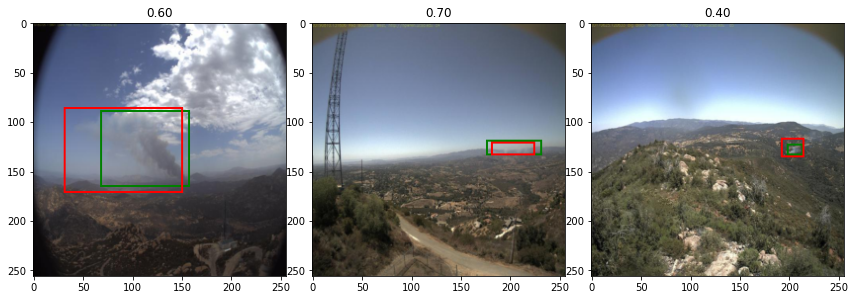

In [40]:
plt.rcParams['figure.figsize'] = (15,10)
plt.subplots_adjust(wspace=0.0,hspace=0.15)

for i,rndi in enumerate([7,5,10]):
    img,label=val_ds[rndi]
    with torch.no_grad():
        label_pred=model(img.unsqueeze(0).to(device))[0].cpu()
    plt.subplot(2,3,i+1)
    show_tensor_2labels(img,label,label_pred)
    
    label_bb = cxcy2bbox(torch.tensor(label).unsqueeze(0))
    label_pred_bb=cxcy2bbox(label_pred.unsqueeze(0))
    iou = torchvision.ops.box_iou(label_bb,label_pred_bb)
    plt.title("%.2f"%iou.item())
    
    if i>4:
        break

(660, 320) (0, 0)
(256, 256) (0.0, 0.0)
torch.Size([3, 256, 256])


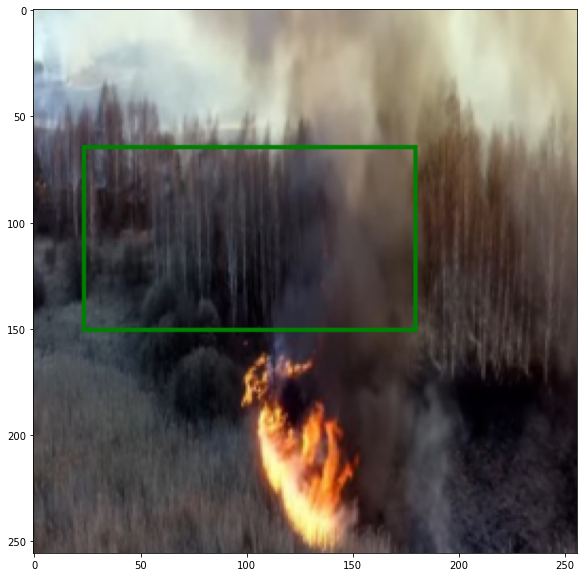

In [117]:
Path2image = "D:\dataSmoke\p10.jpg"
img = Image.open(Path2image)
label = (0,0)
print(img.size,label)

img,label = resize_img_label(img,label,target_size=(256,256))
print(img.size,label)

img=TF.to_tensor(img)
label=scale_label(label,(256,256))
print(img.shape)

with torch.no_grad():
    label_pred=model(img.unsqueeze(0).to(device))[0].cpu()
#show_tensor_2labels(img,label,label_pred)
show_tensor_2labels(img,label_pred)

In [58]:
path2dataf_test = os.path.join(path2data,"test")
path2labels_test = os.path.join(path2dataf_test,"test_labels.csv")
labels_df_test = pd.read_csv(path2labels_test)
x_min = labels_df_test["xmin"]
y_min = labels_df_test["ymin"]
x_max = labels_df_test["xmax"]
y_max = labels_df_test["ymax"]
labels_df_test["centerx"] = x_min+(x_max - x_min)/2
labels_df_test["centery"] = y_min+(y_max - y_min)/2
labels_df_test["w"] = (x_max - x_min)
labels_df_test["h"] = (y_max - y_min)
print(labels_df_test.head())
ids = labels_df_test.index
fullPath2img = [0]*len(ids)
for id_ in ids:
    fullPath2img[id_]=os.path.join(path2data,"test",labels_df_test["filename"][id_])

                                            filename  width  height  class  \
0  ck0t4z1yrkmfv0794t2oqhd3f_jpeg.rf.17653d46c3ee...    640     480  smoke   
1  ck0ujmglz85u10a468qt0d4fc_jpeg.rf.18d02755e8c9...    640     480  smoke   
2  ck0uivtpc841h0a46ydgo7566_jpeg.rf.00134176dc29...    640     480  smoke   
3  ck0nehpd69bax0721onacbe33_jpeg.rf.02ed50fbcb97...    640     480  smoke   
4  ck0ow7vs07tuz08485n4yz5si_jpeg.rf.179fc0e59422...    640     480  smoke   

   xmin  ymin  xmax  ymax  centerx  centery    w   h  
0   514   209   616   285    565.0    247.0  102  76  
1   162   210   635   302    398.5    256.0  473  92  
2   308   206   392   252    350.0    229.0   84  46  
3   274   229   454   311    364.0    270.0  180  82  
4   386   218   607   285    496.5    251.5  221  67  


(640, 480) (0, 0)
(256, 256) (0.0, 0.0)
torch.Size([3, 256, 256])


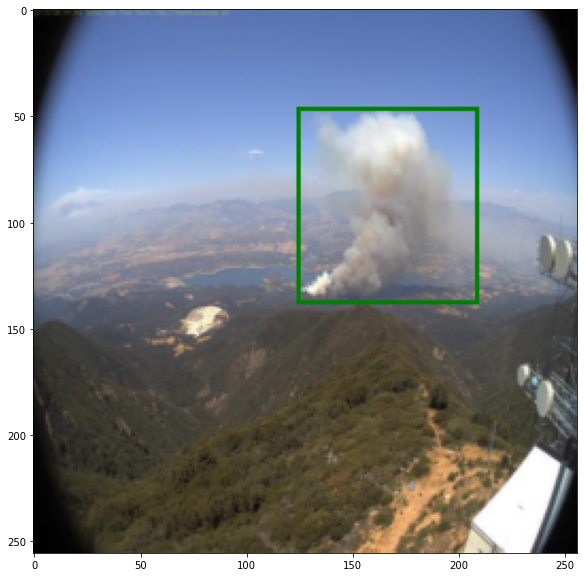

In [85]:
Path2image = fullPath2img[35]
img = Image.open(Path2image)
label = (0,0)
print(img.size,label)

img,label = resize_img_label(img,label,target_size=(256,256))
print(img.size,label)

img=TF.to_tensor(img)
label=scale_label(label,(256,256))
print(img.shape)

with torch.no_grad():
    label_pred=model(img.unsqueeze(0).to(device))[0].cpu()
#show_tensor_2labels(img,label,label_pred)
show_tensor_2labels(img,label_pred)